In [1]:
from google.colab import drive
drive.mount('/content/drive')
caminho_drive = '/content/drive/My Drive/colab/snake/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install keras-rl2

     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 87.9MB 35kB/s 
     |████████████████████████████████| 3.1MB 54.4MB/s 
     |████████████████████████████████| 501kB 48.4MB/s 
  Created wheel for keras-rl2: filename=keras_rl2-1.0.3-cp36-none-any.whl size=52852 sha256=bf3c64324ce4cbdb244234ecbdaf4d480dd393932d2810fce28576e82d19a5d6
  Stored in directory: /root/.cache/pip/wheels/75/70/d7/65d0ca0a87c24f988435973065ef7ddf78af43a603a035aac0
Successfully built keras-rl2
  Found existing installation: tensorflow 2.2.0rc4
    Uninstalling tensorflow-2.2.0rc4:
      Successfully uninstalled tensorflow-2.2.0rc4


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import warnings
from contextlib import redirect_stdout

from sklearn.preprocessing import StandardScaler

import gym
from gym import spaces

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from keras.callbacks.callbacks import LambdaCallback
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
def cria_modelo(n_acoes, input_shape, porc_dropout):

    rna = models.Sequential()
    rna.add(layers.Flatten(input_shape=input_shape))

    rna.add(layers.Dense(256,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(128,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(64,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(32,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(n_acoes, activation='softmax'))

    #rna.compile(optimizer='sgd', loss='mse')
    #rna.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])

    return rna

In [0]:
class SnakeEnv(gym.Env):
    def __init__(self, janela_aprendizado):
        self.n_acoes = 4
        self.action_space = spaces.Discrete(self.n_acoes)
        self.observation_space = spaces.Box( low=-1 , high=1 , shape=(janela_aprendizado,) + (10, 10) )
        self.campo = None
        self.qnt_linhas = None
        self.qnt_colunas = None
        self.posicoes_cobra = None
        self.desconto_por_casa = -0.001
        self.reset()

    def observacao(self):
        obs = []
        for i in range( len(self.campo[0]) ):
            obs.append( self.campo[0][i] )
        return obs

    def step(self, acao):
        
        recompensa = None
        acabou = False
        regret = 0

        posicao_cabeca_x = self.posicoes_cobra[0][0]
        posicao_cabeca_y = self.posicoes_cobra[0][1]
        
        if acao == 0: #cima
            posicao_cabeca_y += -1
        elif acao == 1: #direita
            posicao_cabeca_x += 1
        elif acao == 2: #baixo
            posicao_cabeca_y += 1
        elif acao == 3: #esquerda
            posicao_cabeca_x += -1

        recompensa = self.campo[0][ posicao_cabeca_y ][ posicao_cabeca_x ]

        if recompensa == -1:
            acabou = True
        else:
            self.posicoes_cobra.insert(0, [ posicao_cabeca_x, posicao_cabeca_y ])
            self.campo[0][posicao_cabeca_y][posicao_cabeca_x] = 0

            if recompensa == 1:
                self.gera_maca()
                self.campo[0][ self.posicoes_cobra[1][1] ][ self.posicoes_cobra[1][0] ] = -1
            else:
                self.campo[0][ self.posicoes_cobra[-1][1] ][ self.posicoes_cobra[-1][0] ] = self.desconto_por_casa
                self.posicoes_cobra.pop()
                self.campo[0][ self.posicoes_cobra[1][1] ][ self.posicoes_cobra[1][0] ] = -1

        return self.observacao(), recompensa, acabou, {'regret':regret}

    def gera_maca(self):
        linha = 0
        coluna = 0
        while self.campo[0][linha][coluna] != self.desconto_por_casa:
            linha = np.random.choice( self.qnt_linhas )
            coluna = np.random.choice( self.qnt_colunas )
        self.campo[0][linha][coluna] = 1

    def reset(self):
        self.campo = np.full( self.observation_space.shape, self.desconto_por_casa )
        self.qnt_linhas = len(self.campo[0][0])
        self.qnt_colunas = len(self.campo[0])
        self.campo[0][0] = -1
        self.campo[0][-1] = -1
        for i in range(len(self.campo[0])):
            self.campo[0][i][0] = -1
            self.campo[0][i][-1] = -1
        self.posicoes_cobra = []
        self.posicoes_cobra.append( [int(self.qnt_linhas / 2), int(self.qnt_colunas / 2)] )
        self.posicoes_cobra.append( [self.posicoes_cobra[0][0], self.posicoes_cobra[0][1] + 1] )
        self.campo[0][ self.posicoes_cobra[0][1] ][ self.posicoes_cobra[0][0] ] = 0
        self.campo[0][ self.posicoes_cobra[-1][1] ][ self.posicoes_cobra[-1][0] ] = -1
        self.gera_maca()
        return self.observacao()

    def render(self, mode='human'):
        print()
        for array in self.campo:
            print(array)

In [6]:
np.random.seed(15)

janela_aprendizado = 1 #quantas linhas da memoria vai pegar pra treinar o modelo por vez
ambiente = SnakeEnv( janela_aprendizado ) #cria o ambiente para o jogo
n_acoes = ambiente.n_acoes #define o numero de saidas da rede
input_shape = ambiente.observation_space.shape
batch_size = 32

memoria = SequentialMemory(limit=50000, window_length=janela_aprendizado)
porc_drop_out = 0.2
modelo = cria_modelo( n_acoes, input_shape, porc_drop_out )
metricas = ['accuracy']
otimizador = optimizers.Adam()

n_steps = []
n_steps.append( 500000 )
n_steps.append( 300000 )
n_steps.append( 1000000 )
n_steps_aquecimento = 1000
n_max_steps_por_episodio = 200

politicas = []
politicas.append( LinearAnnealedPolicy( inner_policy=EpsGreedyQPolicy(), attr='eps', value_max=1.0, value_min=0.2, nb_steps=n_steps[0], value_test=0 )  )
politicas.append( EpsGreedyQPolicy( eps=0.2 ) )
politicas.append( GreedyQPolicy() )

agora = str( datetime.now() - timedelta(hours = 3) ).replace(' ', '_') #horario de brasilia UTC-3
caminho_export = '{0}{1}_'.format( caminho_drive, agora )
arquivo_parametros = open( '{0}parametros.txt'.format( caminho_export ), 'w+' )
arquivo_parametros.write( 'input shape = {}\n\n'.format(input_shape) )
arquivo_parametros.write( 'desconto por casa = {}\n\n'.format(ambiente.desconto_por_casa) )
arquivo_parametros.write( 'batch size = {}\n\n'.format(batch_size) )
arquivo_parametros.write( 'modelo =\n'.format() )
with redirect_stdout(arquivo_parametros):
    modelo.summary()
arquivo_parametros.write( '\nmetricas = {}\n\n'.format(metricas) )
arquivo_parametros.write( 'numero de steps = {}\n\n'.format(n_steps) )
arquivo_parametros.write( 'numero de steps de aquecimento = {}\n\n'.format(n_steps_aquecimento) )
arquivo_parametros.write( 'numero maximo de steps por episodio = {}\n\n'.format(n_max_steps_por_episodio) )
arquivo_parametros.write( 'politicas =' )
for politica in politicas:
    arquivo_parametros.write( '\r{} {}'.format(politica, politica.__dict__) )
arquivo_parametros.write( '\n\notimizador = {} {}\n'.format(otimizador, otimizador.__dict__) )
arquivo_parametros.close()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
resultados_treino = []
callbacks_treino = []
for etapa in range( len(n_steps) ):
    callbacks_treino_etapa = []
    callbacks_treino_etapa.append( FileLogger( 'log.log' ) )
    callbacks_treino_etapa.append( FileLogger( '{0}log.log'.format( caminho_export ) ) )
    callbacks_treino_etapa.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_treino.append( {'etapa':etapa, 'logs':logs} ) ) )
    intervalo_modelo = int( n_steps[ etapa ] / 5 )
    callbacks_treino_etapa.append( ModelIntervalCheckpoint( '{0}dqn.h5f'.format( caminho_export ) , interval=intervalo_modelo ) )
    callbacks_treino.append( callbacks_treino_etapa )

for etapa in range( len(n_steps) ):

    agente = DQNAgent( model=modelo, policy=politicas[etapa], nb_actions=n_acoes, memory=memoria, enable_double_dqn=True, test_policy=GreedyQPolicy(), nb_steps_warmup=n_steps_aquecimento, batch_size=batch_size )
    agente.compile( optimizer=otimizador, metrics=metricas )
    if etapa > 0:
        agente.load_weights( 'dqn.h5f' )

    intervalo_log = int( n_steps[ etapa ] / 5 )
    agente.fit( env=ambiente, nb_steps=n_steps[etapa], visualize=False, verbose=1, callbacks=callbacks_treino[ etapa ], log_interval=intervalo_log, nb_max_episode_steps=n_max_steps_por_episodio )
    print()

    agente.save_weights( 'dqn.h5f', overwrite=True )
    agente.save_weights( '{0}dqn.h5f'.format( caminho_export ), overwrite=True )

Training for 500000 steps ...
Interval 1 (0 steps performed)
100000/100000 [==============================] - 1075s 11ms/step - reward: -0.2440
25552 episodes - episode_reward: -0.955 [-1.026, 2.990] - loss: 0.195 - accuracy: 0.403 - mean_q: 0.465 - mean_eps: 0.919 - regret: 0.000

Interval 2 (100000 steps performed)
 80769/100000 [=======================>......] - ETA: 3:17 - reward: -0.2156done, took 1904.680 seconds

Training for 300000 steps ...
Interval 1 (0 steps performed)
 1343/60000 [..............................] - ETA: 3:44 - reward: -0.0865done, took 5.212 seconds

Training for 1000000 steps ...
Interval 1 (0 steps performed)
  1055/200000 [..............................] - ETA: 9:27 - reward: -0.0616done, took 3.059 seconds



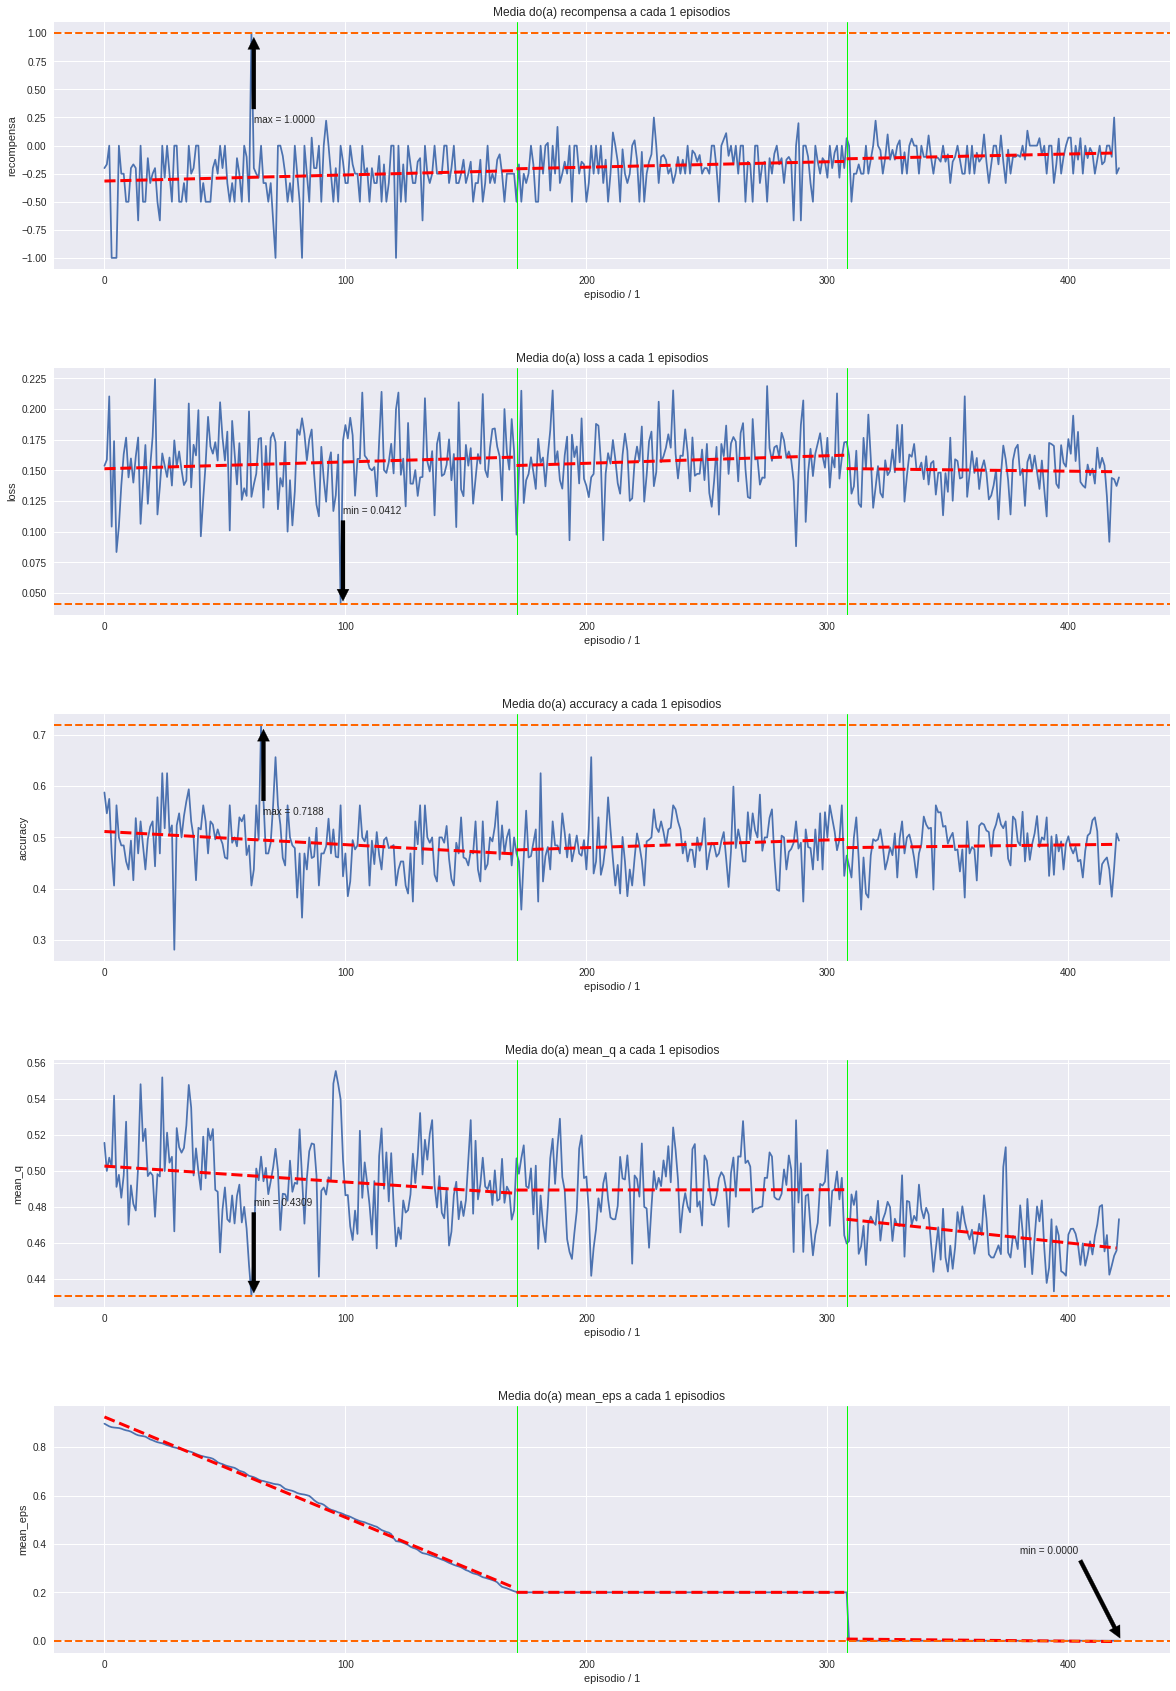

In [0]:
plt.style.use('seaborn')
#nm_metricas = ['recompensa', 'regret', 'loss', 'accuracy', 'mean_q', 'mean_eps']
#metrica_max = [True, True, False, True, False, False]
nm_metricas = ['recompensa', 'loss', 'accuracy', 'mean_q', 'mean_eps']
metrica_max = [True, False, True, False, False]
divisores = [1] #quantidade de episodios a dividir a media
etapas = [d['etapa'] for d in resultados_treino]
result = [d['logs'] for d in resultados_treino]
n_resultados = len(result)
tipo = 'treino_full'
pular_n_steps = n_steps_aquecimento
fig_size_x = 20
fig_size_y = len(nm_metricas) * 6

fig, axs = plt.subplots(len(nm_metricas), len(divisores), gridspec_kw={'hspace': 0.4, 'wspace': 0.2}, figsize=( fig_size_x , fig_size_y ))
for metrica_i in range(len(nm_metricas)):

    nm_metrica = nm_metricas[metrica_i]
    if len(divisores) == 1:
        axs[metrica_i].set(ylabel=nm_metrica)
    else:
        axs[metrica_i][0].set(ylabel=nm_metrica)
    grafico = 0

    for divisor in divisores:

        axes = None
        if len(divisores) == 1:
            axes = axs[metrica_i]
        else:
            axes = axs[metrica_i][grafico]
        grafico = 0
        axes.set(title='Media do(a) {} a cada {} episodios'.format(nm_metrica, divisor))

        hist_metricas = []
        metricas_media = []
        metricas_ref = []

        # [ posicao em x do maior ponto na media , posicao y do maior ponto na media , maior ponto ]
        max_metrica_media = [None, None]
        min_metrica_media = [None, None]

        for i in range(0, n_resultados):
            if not math.isnan( result[i]['metrics'][0] ): #tira os steps de aquecimento
                if metrica_i == 0: #recompensa
                    metricas_ref.append( result[i]['reward'] )
                #elif metrica_i == 1: #regret
                #    metricas_ref.append( result[i]['info']['regret'] )
                else: #outras metricas
                    compara_metrica = metrica_i - 1
                    if compara_metrica == len(result[i]['metrics']): #se for o epsilon
                        if type(politicas[etapas[i]]) == type(EpsGreedyQPolicy()):
                            metricas_ref.append( politicas[etapas[i]].eps )
                        elif type(politicas[etapas[i]]) == type(GreedyQPolicy()):
                            metricas_ref.append( 0 )
                    else:
                        metricas_ref.append( result[i]['metrics'][compara_metrica] )

            if i > 0 and result[i]['episode'] != result[i-1]['episode'] and len(metricas_ref) > 0:
                hist_metricas.append( sum(metricas_ref) / len(metricas_ref) )
                metricas_ref = []

            if len(hist_metricas) % divisor == 0 and len(hist_metricas) > 0:
                metricas_media.append( sum(hist_metricas[-divisor:]) / divisor )
                hist_metricas = []
                #pega maximos e minimos
                if max_metrica_media[1] == None or metricas_media[-1] >= max_metrica_media[1]:
                    max_metrica_media[0] = len(metricas_media)
                    max_metrica_media[1] = metricas_media[-1]
                if min_metrica_media[1] == None or metricas_media[-1] <= min_metrica_media[1]:
                    min_metrica_media[0] = len(metricas_media)
                    min_metrica_media[1] = metricas_media[-1]
        

        #plota grafico
        n_steps_media_total = len(metricas_media)
        x_plot = np.arange(n_steps_media_total)
        axes.set(xlabel='episodio / {}'.format(divisor))
        axes.plot(x_plot, metricas_media)

        n_episodios_ant = 0
        pular_n_episodes = 0
        for i in range( len(n_steps) ):

            n_episodios = 0
            step_inicial = 0
            step_final = 0
            for j in range(i+1):
                step_final += n_steps[j] - 1
                n_episodios += result[step_final]['episode']
                step_final += 1
            for j in range(i):
                step_inicial += n_steps[j] - 1
            step_inicial += pular_n_steps

            pular_n_episodes += result[step_inicial]['episode']
            n_episodios -= pular_n_episodes

            #linha de tendencia
            z = np.polyfit( x_plot[ n_episodios_ant : n_episodios ], metricas_media[ n_episodios_ant : n_episodios ], 1 )
            p = np.poly1d(z)
            axes.plot( x_plot[ n_episodios_ant : n_episodios ], p(x_plot[ n_episodios_ant : n_episodios ]), c='#ff0000', ls="--", linewidth=3, label='tendencia etapa {}'.format(i) )

            if i < len(n_steps) - 1:
                #linha de separacao de treinos
                axes.axvline( x=n_episodios, c='#00ff00' , linewidth=1, label='divisor das etapas {} da {}'.format(i, i+1) )

            n_episodios_ant = n_episodios
        
        #maximo e minimo
        if metrica_max[metrica_i]:
            #linha de maximo
            anotacao_x_max = max_metrica_media[0]
            if max_metrica_media[0] > n_steps_media_total / 2:
                anotacao_x_max = n_steps_media_total * 0.9
            anotacao_y_max = ((max_metrica_media[1] - min_metrica_media[1]) * 0.6) + min_metrica_media[1]
            axes.axhline(max_metrica_media[1], c='#ff6600', ls='--', linewidth=2, label='maximo_1')
            axes.annotate( 'max = {:.4f}'.format(max_metrica_media[1]), 
                                            xy=( max_metrica_media[0] , max_metrica_media[1] ),
                                            xytext=( anotacao_x_max , anotacao_y_max ),
                                            arrowprops=dict(facecolor='black', shrink=0.05) )
        else:
            #linha de minimo
            anotacao_x_min = min_metrica_media[0]
            if min_metrica_media[0] > n_steps_media_total / 2:
                anotacao_x_min = n_steps_media_total * 0.9
            anotacao_y_min = ((max_metrica_media[1] - min_metrica_media[1]) * 0.4) + min_metrica_media[1]
            axes.axhline(min_metrica_media[1], c='#ff6600', ls='--', linewidth=2, label='minimo_1')
            axes.annotate( 'min = {:.4f}'.format(min_metrica_media[1]),
                                            xy=( min_metrica_media[0] , min_metrica_media[1] ),
                                            xytext=( anotacao_x_min , anotacao_y_min ),
                                            arrowprops=dict(facecolor='black', shrink=0.03) )
        
        grafico += 1

fig.show()
fig.savefig('result_{}.png'.format(tipo), bbox_inches='tight') #salva o grafico em uma foto
fig.savefig('{0}result_{1}.png'.format( caminho_export, tipo ), bbox_inches='tight') #salva o grafico em uma foto

In [0]:
ambiente = SnakeEnv( 1 ) #cria o ambiente para o jogo

agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria, test_policy=GreedyQPolicy() )
agente.compile(optimizers.Adam(), metrics=metricas)
agente.load_weights('dqn_2.h5f')

n_max_steps_por_episodio_test = 100

resultados_teste = []
callbacks_teste = []
callbacks_teste.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_teste.append( logs ) ) )
agente.test(ambiente, nb_episodes=10, verbose=1, visualize=False, callbacks=callbacks_teste, nb_max_episode_steps=n_max_steps_por_episodio_test)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Testing for 10 episodes ...
Episode 1: reward: -0.006, steps: 8
Episode 2: reward: -1.007, steps: 8
Episode 3: reward: -1.007, steps: 8
Episode 4: reward: 1.984, steps: 20
Episode 5: reward: 1.975, steps: 29
Episode 6: reward: 1.975, steps: 29
Episode 7: reward: -0.100, steps: 100
Episode 8: reward: -1.007, steps: 8
Episode 9: reward: 0.993, steps: 10
Episode 10: reward: 3.975, steps: 31


In [0]:
def pinta_mais( x, y, tamanho, data, cor ):
    for i in range(tamanho):
        for j in range(tamanho):
            data[tamanho * x + i][tamanho * y + j] = cor

import cv2

# initialize water image
tamanho = 20
tamanho_x = ambiente.observation_space.shape[1] * tamanho
tamanho_y = ambiente.observation_space.shape[2] * tamanho
water_depth = np.zeros((tamanho_y, tamanho_x), dtype=float)

# initialize video writer
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
fps = 3
video_filename = '{0}test.mp4'.format( caminho_export )
out = cv2.VideoWriter(video_filename, fourcc, fps, (tamanho_x, tamanho_y))
contagem = 0

for log in resultados_teste:
    data = np.zeros( (tamanho_x, tamanho_y, 3), dtype=np.uint8 )
    for i in range(int(tamanho_x / tamanho)):
        for j in range(int(tamanho_y / tamanho)):
            if log['observation'][j][i] == 1:
                pinta_mais(i, j, tamanho, data, [0,0,255] ) #red
            elif i == 0 or j == 0 or i == int(tamanho_x / tamanho) - 1 or j == int(tamanho_y / tamanho) - 1:
                pinta_mais(i, j, tamanho, data, [255,0,0] ) #blue
            elif log['observation'][j][i] == ambiente.desconto_por_casa:
                pinta_mais(i, j, tamanho, data, [255,255,255] )
            elif log['observation'][j][i] == 0:
                pinta_mais(i, j, tamanho, data, [0,100,0] ) #green
            else:
                pinta_mais(i, j, tamanho, data, [0,255,0] ) #green
            
    if contagem > 0 and resultados_teste[contagem]['episode'] != resultados_teste[contagem-1]['episode']:
        data.fill(0)
        out.write(data)
        out.write(data)
    contagem += 1

    out.write(data)

# close out the video writer
out.release()

In [0]:
for log in resultados_teste:
    print('episodio {}'.format(log['episode']))
    print('acao {}'.format(log['action']))
    for array in log['observation']:
        print(array)
    print()
    print()

episodio 0
acao 0
[-1. -1. -1. -1. -1. -1. -1.]
[-1.    -0.001 -0.001 -0.001 -0.001 -0.001 -1.   ]
[-1.    -0.001 -0.001  0.    -0.001 -0.001 -1.   ]
[-1.    -0.001 -0.001 -1.    -0.001 -0.001 -1.   ]
[-1.    -0.001 -0.001 -0.001 -0.001 -0.001 -1.   ]
[-1.    -0.001 -0.001  1.    -0.001 -0.001 -1.   ]
[-1. -1. -1. -1. -1. -1. -1.]


episodio 0
acao 2
[-1. -1. -1. -1. -1. -1. -1.]
[-1.    -0.001 -0.001 -0.001 -0.001 -0.001 -1.   ]
[-1.    -0.001 -0.001  0.    -0.001 -0.001 -1.   ]
[-1.    -0.001 -0.001 -1.    -0.001 -0.001 -1.   ]
[-1.    -0.001 -0.001 -0.001 -0.001 -0.001 -1.   ]
[-1.    -0.001 -0.001  1.    -0.001 -0.001 -1.   ]
[-1. -1. -1. -1. -1. -1. -1.]


episodio 1
acao 0
[-1. -1. -1. -1. -1. -1. -1.]
[-1.    -0.001 -0.001 -0.001 -0.001 -0.001 -1.   ]
[-1.    -0.001 -0.001  0.    -0.001 -0.001 -1.   ]
[-1.    -0.001 -0.001 -1.    -0.001 -0.001 -1.   ]
[-1.    -0.001 -0.001 -0.001 -0.001 -0.001 -1.   ]
[-1.     1.    -0.001 -0.001 -0.001 -0.001 -1.   ]
[-1. -1. -1. -1. -1. -1. -1

In [0]:
ambiente = SnakeEnv( 1 )

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
ambiente.render()
ambiente.step(2)
ambiente.render()


[[-1.    -1.    -1.    -1.    -1.    -1.    -1.   ]
 [-1.    -0.001 -0.001 -0.001 -0.001 -0.001 -1.   ]
 [-1.    -0.001 -0.001 -0.001 -0.001 -0.001 -1.   ]
 [-1.    -0.001 -0.001  0.    -0.001 -0.001 -1.   ]
 [-1.    -0.001 -0.001 -1.    -0.001 -0.001 -1.   ]
 [-1.    -0.001 -0.001 -0.001 -0.001  1.    -1.   ]
 [-1.    -1.    -1.    -1.    -1.    -1.    -1.   ]]

[[-1.    -1.    -1.    -1.    -1.    -1.    -1.   ]
 [-1.    -0.001 -0.001 -0.001 -0.001 -0.001 -1.   ]
 [-1.    -0.001 -0.001 -0.001 -0.001 -0.001 -1.   ]
 [-1.    -0.001 -0.001  0.    -0.001 -0.001 -1.   ]
 [-1.    -0.001 -0.001 -1.    -0.001 -0.001 -1.   ]
 [-1.    -0.001 -0.001 -0.001 -0.001  1.    -1.   ]
 [-1.    -1.    -1.    -1.    -1.    -1.    -1.   ]]
